# Recap

## Generative Models

**Generative models:** capture the joint probability `P(X, Y)`, or `P(X)` if there are no labels.

**Discriminative model:** capture conditional probability `P(X|Y)`

## Generative Adversarial Networks

### Main idea

Discriminator $D$ and Generator $G$ compete at the same time during training.

- Generator: generate plausible data from random input noise
- Discriminator: distinguish the generator's fake data from real data

<center><img src="https://developers.google.com/static/machine-learning/gan/images/gan_diagram.svg " width="600" /><center>


### Training pipeline

Generator:
- Sample a random noise
- Generate output $G_{o}$
- Get discriminator "Real" or "Fake" classification for $G_{o}$
- Calculate loss from $D$ classification
- Backpropagate through both $G$ and $D$
- Use gradient to change only the generator weights.

Discriminator:
- Use only $D$ loss, which penalizes $D$ for misclassifying a real as fake and vice versa
- Classify data from $G_{o}$
- Update weights via backpropagation

Alternating training:
- train $D$ with reall samples
- train $D$ with generate fake amples
- train $G$ to fool $D$
- Repeat

### Training Objective

Minimax game: **minimize** $G$'s reconstruction loss while **maximizing** $D$'s performance or **Jensen-Shannon** divergence.

$$ min_{G} max_{D} E_{x}[log(D(x))] + E_{z}[log(1 - D(G(z)))]$$

where:
- $D(x)$: $D$'s estimate of the probability that real data x is real
- $G(z)$: $G$'s output of given noise $z$
- $D(G(z))$: $D$'s estimate of the probability that fake instance is real
- $E_{x}$: expected value over all real data instance
- $E_{z}$: expected value over all random inputs to the generator

### Problems and Solutions

1. Vanishing gradients: if $D$ is too good, it does not provide enough information for the generator

    → modify loss (Wasserstein loss)
2. Mode Collapse: if $G$ produces an especially plausible output, it will learn to produce **only** that output

    → Wasserstein loss, condition GAN

3. Fail to converge:

    → add noise to discriminator inputs, penalizing discriminator weights



### Type of GANs

# 1. Conditional GANs: use a labeled set of data so that generated instance can be specified.
![Alt-text](https://www.researchgate.net/profile/Sara-Narteni-2/publication/366488120/figure/fig1/AS:11431281109613837@1672129900178/Conditional-GAN-scheme.ppm)


A **cGAN** consists of two neural networks:

- **Generator (G)**: Learns to generate realistic data samples `G(z|y)`, where `z` is random noise and `y` is the condition.
- **Discriminator (D)**: Learns to distinguish between real data `x` and fake data `G(z|y)`, given the condition `y`.

## Objective Function:
$$min_G max_D E_{x,y ~ pdata}[log D(x|y)] + E_{z ~ pz, y ~ pdata}[log(1 - D(G(z|y)|y))]$$

## Inputs and Outputs

- **Input to G**: Noise vector `z` and condition `y`
- **Input to D**: Either real pair `(x, y)` or fake pair `(G(z|y), y)`
- **Output of G**: Synthetic data sample (e.g., image)
- **Output of D**: Probability that the input pair is real
## Training pipeline 
1. **Sample Real Data**  
   Begin by sampling a batch of real data `x_real` along with the corresponding condition `y` from the dataset. This condition could be a class label, an image, or any other auxiliary input that guides generation.

2. **Sample Noise Vector**  
   Generate a batch of random noise vectors `z` (typically from a standard normal distribution). This noise is used as the stochastic input to the generator.

3. **Generate Fake Samples**  
   Feed the noise vector `z` and the condition `y` into the **generator** to produce fake data samples `x_fake`.

4. **Train the Discriminator (D)**  
   - Feed real data pairs `(x_real, y)` into the discriminator and obtain its output prediction, indicating how real the samples appear.
   - Feed fake data pairs `(x_fake, y)` (produced by the generator) into the discriminator.
   - Compute the discriminator loss by comparing its outputs on real and fake pairs. The goal is for the discriminator to correctly classify real samples as real and fake samples as fake.
   - Backpropagate the loss and update the discriminator’s parameters using gradient descent.

5. **Train the Generator (G)**  
   - Generate a new set of fake samples `x_fake` using the current generator.
   - Pass these fake samples (along with their conditions `y`) through the discriminator again.
   - Compute the generator loss based on how well the generator fools the discriminator (i.e., the discriminator should classify the fake samples as real).
   - Backpropagate this loss and update the generator’s parameters.

6. **Repeat**  


# 2. CycleGAN:  learn to transform images from one set into images that could plausibly belong to another set.
![Alt-text](https://www.tensorflow.org/static/tutorials/generative/images/horse2zebra_1.png)

# 3. Super-resolution

![Alt-text](https://www.mdpi.com/applsci/applsci-10-01729/article_deploy/html/images/applsci-10-01729-g006a.png)

# Code demo: Simple GAN

## Imports

In [ ]:
import numpy as np
import os
from PIL import Image

import torchvision.utils as vutils
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

## Dataset

In this demo, we will use Roman MNIST dataset. It contains handwritten Roman numerals from I to X. The dataset is already splitted into 3 sets: train, val, and test. Each class contains a total of 1000 images (all sets). For more details, please check [EMNIST](https://www.kaggle.com/datasets/agneev/emnistbased-handwritten-roman-numerals)

In [ ]:
#!/bin/bash
!curl -L -o emnistbased-handwritten-roman-numerals.zip\
  https://www.kaggle.com/api/v1/datasets/download/agneev/emnistbased-handwritten-roman-numerals

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 9343k  100 9343k    0     0  3960k      0  0:00:02  0:00:02 --:--:-- 6057k


In [ ]:
# Unzip the dataset
!unzip -q emnistbased-handwritten-roman-numerals.zip -d dataset

Now, we create a class to handle the dataset based on Pytorch implementation.

In [ ]:
class RomanMNISTDataset(Dataset):
    base_path = r"dataset/500_each_EMNIST-based-Roman"

    def __init__(self, split="train", transform=None):
        self.data_path = os.path.join(self.base_path, split)
        self.image_paths = []
        self.labels = []
        self.transform = transform

        # Map Roman class to numerical representation
        self.label_map = {'i':1, 'ii':2, 'iii':3, 'iv':4, 'v':5, 'vi':6, 'vii':7, 'viii':8, 'ix':9, 'x':10}

        # Loop through the folders and add image path + its label to the corresponding list
        for label in os.listdir(self.data_path):
            class_dir = os.path.join(self.data_path, label)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(".ini"):
                        continue
                    img_path = os.path.join(class_dir, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(self.label_map[label])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
# Resize the image to match the MNIST data
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

train_dataset = RomanMNISTDataset(split="train", transform=transform)
val_dataset = RomanMNISTDataset(split="val", transform=transform)
test_dataset = RomanMNISTDataset(split="test", transform=transform)


Next, we create dataloader for each set of data. In this implementation, `drop_last` is set to `True` to ignore the last batch (when the number of examples in your dataset is not divisible by `batch_size`)

In [ ]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([16, 1, 28, 28])
Image label dimensions: torch.Size([16])


Visualization of training data

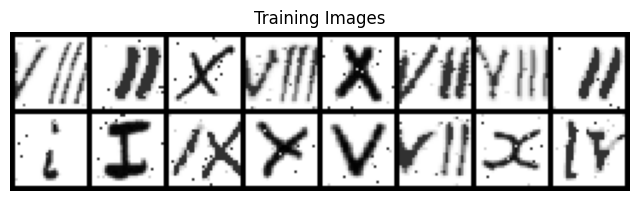

In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Generator

Generator is one part in the MiniMax game of GANs. The purpose of the Generator is to generate plausible data from the sample noise. In this example, we only use **Linear** layers. Later you can explore more complex architecture by adding ***Convolutional layer***.

In [ ]:
class Generator(nn.Module):
    def __init__(self, zdim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(zdim, 128)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, 784)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))


## Discriminator

The other part of GANs is the Discriminator. A Discriminator is simply a **classifier**. It tries to distinguish real data from the data created by the generator. In this example, we also use only **Linear** layers and left the **Convolution** implementation for you.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)


    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        # x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        # x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        # x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))


## Model setup

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
z_dim = 50
data_dim = 28*28

In [ ]:
# Create the generator and discriminator
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

# Loss function
criterion = nn.BCELoss()

lr = 0.0002
# Optimizers
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

## Model training

In [ ]:
num_epochs = 20

D_losses = []
G_losses = []
img_list = []

for epoch in range(num_epochs):
    for batch_idx, (real_images, targets) in enumerate(train_loader):
        real_images = real_images.view(-1, 784).to(device)
        batch_size = real_images.size(0)

        # Train discriminator with real images
        D_optimizer.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        real_outputs = D(real_images)
        D_loss_real = criterion(real_outputs, real_labels)

        # Train discriminator with generated images
        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = G(z)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        fake_outputs = D(fake_images)
        D_loss_fake = criterion(fake_outputs, fake_labels)
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward()
        D_optimizer.step()

        # Train generator
        G_optimizer.zero_grad()
        z2 = torch.randn(batch_size, z_dim).to(device)
        fake_images2 = G(z2)
        fake_outputs2 = D(fake_images2)
        real_labels2 = torch.ones(batch_size, 1).to(device)
        G_loss = criterion(fake_outputs2, real_labels2)
        G_loss.backward()
        G_optimizer.step()

        # Append losses to lists
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

        # Print and plot losses at regular intervals
        if batch_idx % 200 == 0 or batch_idx == len(train_loader):
            print(f'[{epoch}/{num_epochs}][{batch_idx}/{len(train_loader)}]\tLoss_D: {D_loss.item()}\tLoss_G: {G_loss.item()}')

        # Check how the generator is doing by saving G's output on fixed_noise
        # We can later visualize how the images get better during training
        if (batch_idx % 200 == 0) or ((epoch == num_epochs - 1) and (batch_idx == len(train_loader)-1)):
            with torch.no_grad():
                latent_space_samples = torch.randn((16, z_dim)).to(device)
                # print(latent_space_samples.shape)
                generated_features = G(latent_space_samples).cpu().detach() # Generate images from random samples
                # print(generated_features.shape)
                generated_features = generated_features.view(-1, 28, 28).unsqueeze(1) # reshape to normal image
                # print(generated_features.shape)
                img_list.append(vutils.make_grid(generated_features, padding=2, normalize=True))

    # print(f'Epoch [{i+1}/{num_epochs}], Discriminator Loss: {D_loss.item():.4f}, Generator Loss: {G_loss.item():.4f}')


[0/20][0/430]	Loss_D: 0.15865270793437958	Loss_G: 3.9781947135925293
[0/20][200/430]	Loss_D: 0.35263705253601074	Loss_G: 3.1916000843048096
[0/20][400/430]	Loss_D: 0.30395573377609253	Loss_G: 2.245772361755371
[1/20][0/430]	Loss_D: 0.2967996299266815	Loss_G: 1.7947572469711304
[1/20][200/430]	Loss_D: 0.09678977727890015	Loss_G: 6.815570831298828
[1/20][400/430]	Loss_D: 0.850886344909668	Loss_G: 1.5754905939102173
[2/20][0/430]	Loss_D: 0.9960187673568726	Loss_G: 0.17480455338954926
[2/20][200/430]	Loss_D: 0.2070634514093399	Loss_G: 9.317317008972168
[2/20][400/430]	Loss_D: 0.2823326587677002	Loss_G: 3.58077335357666
[3/20][0/430]	Loss_D: 0.9381877183914185	Loss_G: 1.6599981784820557
[3/20][200/430]	Loss_D: 0.20549649000167847	Loss_G: 2.2139010429382324
[3/20][400/430]	Loss_D: 0.9509105086326599	Loss_G: 5.64204216003418
[4/20][0/430]	Loss_D: 0.27040815353393555	Loss_G: 3.3702094554901123
[4/20][200/430]	Loss_D: 1.0171124935150146	Loss_G: 7.72165060043335
[4/20][400/430]	Loss_D: 0.3491384

## Visualize results

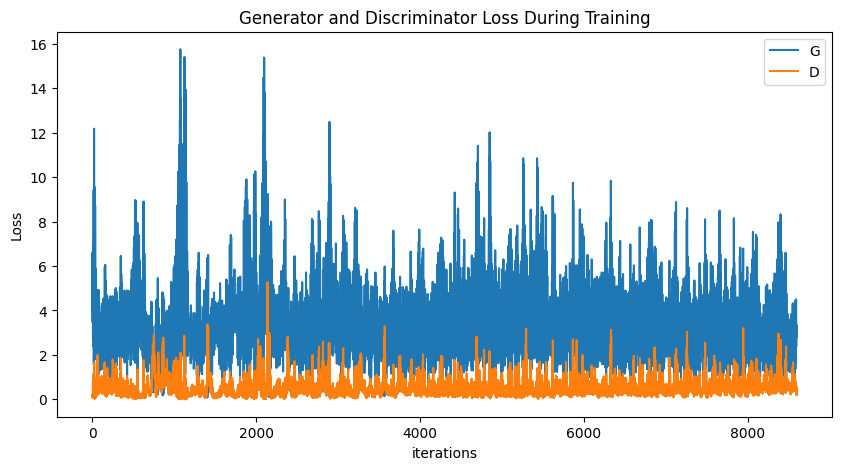

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

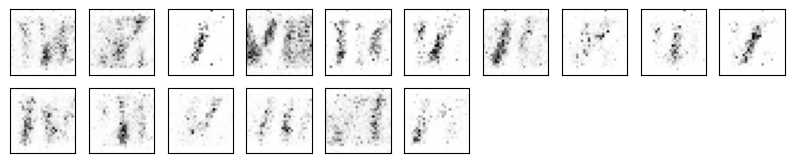

In [ ]:
z = torch.randn(batch_size, z_dim).to(device)
generated_images = G(z).detach().cpu()

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(10, 10)
for j, sample in enumerate(generated_images):
  ax = plt.subplot(gs[j])
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

Now we train our GANs model. It alternates between Generator and Discriminator. Read the comments in the code for more details.

<center><img src="https://miro.medium.com/v2/resize:fit:601/1*Y_AGVp0EEGEpB1Q25G6edQ.jpeg" width="600" /> <center>


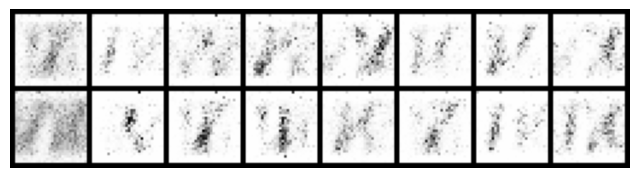

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
#%%capture
fig = plt.figure(figsize=(8, 4))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())